In [5]:
import numpy as np
import pandas as pd
from google.cloud import bigquery, storage
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, t
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import math
import statsmodels.api as sm
from typing import Union
import logging
import sys
from google.cloud.exceptions import NotFound
import time
import os
import json
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.auth import default
from typing import Union
from datetime import date, timedelta, datetime
from tqdm.auto import tqdm
import fastparquet as fp
import io


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ],
    force=True
)


# ------------------------------------------------------------------------------
# Data Queries
# ------------------------------------------------------------------------------

def get_marketing_data(entities, week):
    
    mkt_data = f"""

    WITH holdout_entities AS (
    SELECT
            entity_id,
            `Release Date` AS release_date
    FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
    WHERE `Release Date` < '{week}'
    AND entity_id in {entities}
    ),
    orders as (
    SELECT
         dps.entity_id entity_id
        ,dps.dps_customer_id customer_id
        ,COUNT(case when mkt.order_date <= e.release_date then mkt.order_id end) AS orders_pre
        ,COUNT(case when mkt.order_date > e.release_date then mkt.order_id end) AS orders_post
        ,SUM(case when mkt.order_date <= e.release_date then mkt.analytical_profit end) AS analytical_profit_pre
        ,SUM(case when mkt.order_date > e.release_date then mkt.analytical_profit end) AS analytical_profit_post
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
    JOIN holdout_entities AS e
        ON dps.entity_id = e.entity_id
    left join fulfillment-dwh-production.curated_data_shared_mkt.bima_order_profitability mkt
        ON mkt.global_entity_id = dps.entity_id
        AND mkt.order_id = dps.platform_order_code
        AND order_date >= DATE_SUB(release_date, INTERVAL 8 WEEK)
        AND order_date < '{week}'
        AND global_entity_id in {entities}
    WHERE dps.created_date >= DATE_SUB(e.release_date, INTERVAL 8 WEEK) 
        AND dps.created_date < '{week}'
        AND dps.platform_order_code IS NOT NULL
        AND dps.is_own_delivery
        AND dps.is_sent
        AND vendor_vertical_parent IN ('Restaurant','restaurant','restaurants')
        AND dps.entity_id in {entities}
    GROUP BY 1, 2
    ), 
    customer_information AS (
    SELECT
            e.entity_id,
            e.release_date,
            CASE WHEN d.created_date <= e.release_date THEN FALSE ELSE COALESCE(is_customer_holdout, FALSE) END AS is_customer_holdout,
            d.customer_id
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    JOIN holdout_entities AS e
            ON d.entity_id = e.entity_id
    LEFT JOIN `fulfillment-dwh-production.cl._bad_dps_logs_ids` bad_ids
        ON d.customer_id = bad_ids.id
    WHERE d.created_date >= '2025-01-01' 
        AND d.created_date < '{week}'
        AND d.customer_id IS NOT NULL
        AND bad_ids.id IS NULL
        AND d.entity_id in {entities}
    GROUP BY 1, 2, 3, 4
    )
    SELECT 
            e.entity_id,
            e.customer_id,
            e.is_customer_holdout,
            o.orders_pre,
            o.orders_post,
            o.analytical_profit_pre,
            o.analytical_profit_post
    FROM customer_information e
    LEFT JOIN orders o
        ON o.customer_id = e.customer_id
        AND o.entity_id = e.entity_id

    """

    return mkt_data

def get_dps_data(entities, week):

    dps_data = f"""

    WITH holdout_entities AS (
    SELECT
            entity_id,
            `Release Date` AS release_date
    FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
    WHERE `Release Date` < '{week}'
    AND entity_id not in {entities}
    ),
    orders as (
    SELECT
        dps.entity_id entity_id
        ,dps.dps_customer_id customer_id
        ,COUNT(case when dps.created_date <= e.release_date then dps.platform_order_code end) AS orders_pre
        ,COUNT(case when dps.created_date > e.release_date then dps.platform_order_code end) AS orders_post
        ,SUM(case when dps.created_date <= e.release_date then dps.fully_loaded_gross_profit_eur end) AS analytical_profit_pre
        ,SUM(case when dps.created_date > e.release_date then dps.fully_loaded_gross_profit_eur end) AS analytical_profit_post
    FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
    JOIN holdout_entities AS e
        ON dps.entity_id = e.entity_id
    WHERE dps.created_date >= DATE_SUB(e.release_date, INTERVAL 8 WEEK) 
        AND dps.created_date < '{week}'
        AND dps.platform_order_code IS NOT NULL
        AND dps.is_own_delivery
        AND dps.is_sent
        AND vendor_vertical_parent IN ('Restaurant','restaurant','restaurants')
        AND dps.entity_id not in {entities}
    GROUP BY 1, 2
    ), 
    customer_information AS (
    SELECT
            e.entity_id,
            e.release_date,
            CASE WHEN d.created_date <= e.release_date THEN FALSE ELSE COALESCE(is_customer_holdout, FALSE) END AS is_customer_holdout,
            d.customer_id
    FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
    JOIN holdout_entities AS e
            ON d.entity_id = e.entity_id
    LEFT JOIN `fulfillment-dwh-production.cl._bad_dps_logs_ids` bad_ids
        ON d.customer_id = bad_ids.id
    WHERE d.created_date BETWEEN '2025-01-01' AND '{week}'
        AND d.customer_id IS NOT NULL
        AND bad_ids.id IS NULL
    GROUP BY 1, 2, 3, 4
    )
    SELECT 
    e.entity_id,
    e.customer_id,
    e.is_customer_holdout,
    o.orders_pre,
    o.orders_post,
    o.analytical_profit_pre,
    o.analytical_profit_post
    FROM customer_information e
    LEFT JOIN orders o
    ON o.customer_id = e.customer_id
    AND o.entity_id = e.entity_id

    """

    return dps_data

# ------------------------------------------------------------------------------
# Data Extraction
# ------------------------------------------------------------------------------

def initialize_bigquery_client(project_id_pass):
   
    project_id = project_id_pass 

    logging.info(f"Initializing BigQuery client for project: {project_id}")

    if os.getenv("GITHUB_ACTIONS"):
        credentials_path = "/tmp/credentials.json" 
    else:
        credentials, project = default()  
        project_id = project if project else project_id 

    if os.getenv("GITHUB_ACTIONS") and not os.path.exists(credentials_path):
        raise FileNotFoundError(f"Credentials file not found at {credentials_path}. Make sure to set up authentication in GitHub Actions.")

    if os.getenv("GITHUB_ACTIONS"):
        with open(credentials_path, "r") as f:
            creds_data = json.load(f)

        credentials = Credentials.from_authorized_user_info(creds_data)

        if credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())

    try:
        client = bigquery.Client(credentials=credentials, project=project_id)
        logging.info(f"BigQuery client initialized successfully for project: {project_id}")
        return client 
    except Exception as e:
        logging.error(f"Failed to initialize BigQuery client: {e}")
        raise e


def get_iso_week_mondays(year, min_date=None, max_date=None):
    d = date(year, 1, 4)
    d -= timedelta(days=d.weekday())  # Get Monday of ISO week 1

    mondays = []
    while d.year <= year or (d.year == year + 1 and d.isocalendar()[1] == 1):
        if (
            d.isocalendar()[0] == year and
            (min_date is None or d > min_date) and
            (max_date is None or d <= max_date)
        ):
            mondays.append(d)
        d += timedelta(weeks=1)

    return mondays

def combined_data(client, mkt, dps):
    
    try:
        mkt_df = client.query(mkt).to_dataframe()
    except Exception as e:
        logging.error(f"Error executing marketing data query: {e}")
        mkt_df = pd.DataFrame() 

    # try:
    #     dps_df = client.query(dps).to_dataframe()
    # except Exception as e:
    #     logging.error(f"Error executing DPS data query: {e}")
    #     dps_df = pd.DataFrame()

    # combined = pd.concat([mkt_df, dps_df], ignore_index=True)

    return mkt_df


def extract_data(client, mkt_data, dps_data):
    
    start_time = time.time()
    logging.info(f"start_time: {start_time:.2f}")

    combined_df = combined_data(client,mkt_data, dps_data)
    elapsed_time = time.time() - start_time
    logging.info(f"Time to extract and combine data from DB: {elapsed_time:.2f} seconds")
    
    return combined_df 


def get_cumm_data(project,entities, week):

    client = initialize_bigquery_client(project)
    
    final_df = pd.DataFrame()

    for w_no in week:
        
        print(f"Querying for week starting {w_no}")
        
        tmp = extract_data(client ,get_marketing_data(entities, w_no), get_dps_data(entities,w_no))

        # Add the as_of_date column
        tmp["as_of_date"] = w_no

        # Append to the final dataframe
        final_df = pd.concat([final_df, tmp], ignore_index=True)

    return final_df


# ------------------------------------------------------------------------------
# Data Clean Up
# ------------------------------------------------------------------------------

def fill_nans(df):

    df = df.fillna({
        'orders_pre': 0,
        'orders_post': 0,
        'analytical_profit_pre': 0,
        'analytical_profit_post': 0,
    })

    return df

def drop_users_with_no_data(df):

    mask1 = (
        (df['orders_pre'] == 0) &
        (df['orders_post'] == 0) &
        (df['analytical_profit_pre'] == 0) &
        (df['analytical_profit_post'] == 0)
    )

    mask2 = (
        (df['orders_pre'].isna()) &
        (df['orders_post'].isna()) &
        (df['analytical_profit_pre'].isna()) &
        (df['analytical_profit_post'].isna())
    ) 

    df = df[~(mask1 |   mask2)]
    
    return df

def apply_cleanup(df):

    #NaN's are converted to 0's where applicable
    data_cleaned = fill_nans(df) 
    
    #remove customers with no data in the pre and the post period
    raw_data_final = drop_users_with_no_data(data_cleaned)

    return raw_data_final

# ------------------------------------------------------------------------------
# Performing Statistical Analysis
# ------------------------------------------------------------------------------


## Confidence Intervals for separate groups ##

def bootstrap_single_group(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 1000,
    alpha: float = 0.05,
    seed: int = 42
) -> dict:
    
    # Drop NaNs for safety
    group = df[adjusted_metric].dropna().values

    if len(group) == 0:
        raise ValueError(f"No valid data found for metric: {adjusted_metric}")

    # If all values are the same, skip bootstrap
    if np.all(group == group[0]):
        mean_val = group[0]
        return {
            "mean": round(mean_val, 4),
            "ci": (round(mean_val, 4), round(mean_val, 4))
        }

    # Use scipy's bootstrap with percentile CI
    res = stats.bootstrap(
        (group,),
        statistic=np.mean,
        n_resamples=n_resamples,
        method='percentile',
        confidence_level=1 - alpha,
        random_state=seed
    )

    bootstrap_means = res.bootstrap_distribution
    ci = res.confidence_interval
    mean_val = np.mean(group)
    bootstrap_mean = np.mean(bootstrap_means)

    return {
        "mean": round(mean_val, 4),
        "ci": (round(ci.low, 4), round(ci.high, 4)),
        "bootstrap_mean": round(bootstrap_mean, 4),
        "bootstrap_means" : bootstrap_means
    }

def plot_bootstrap_single_distribution(boot_result: dict, alpha: float = 0.05):
    
    boot_means = boot_result["bootstrap_means"]
    mean_val = boot_result["mean"]
    ci_low, ci_high = boot_result["ci"]

    plt.figure(figsize=(10, 6))
    plt.hist(boot_means, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val}')
    plt.axvline(ci_low, color='green', linestyle='--', linewidth=2, label=f'{100*(1-alpha):.0f}% CI Low: {ci_low}')
    plt.axvline(ci_high, color='green', linestyle='--', linewidth=2, label=f'{100*(1-alpha):.0f}% CI High: {ci_high}')
    
    plt.title("Bootstrap Distribution of the Mean")
    plt.xlabel("Mean Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_bootstrap_comparison_single_group(
    result1: dict, label1: str,
    result2: dict, label2: str,
    alpha: float = 0.05
):
    plt.figure(figsize=(12, 6))

    # Plot 1
    plt.hist(result1["boot_means"], bins=50, alpha=0.5, label=f'{label1} Dist', edgecolor='black')
    plt.axvline(result1["mean"], color='red', linestyle='--', label=f'{label1} Mean: {result1["mean"]}')
    plt.axvline(result1["ci"][0], color='green', linestyle='--', label=f'{label1} CI Low: {result1["ci"][0]}')
    plt.axvline(result1["ci"][1], color='green', linestyle='--', label=f'{label1} CI High: {result1["ci"][1]}')

    # Plot 2
    plt.hist(result2["boot_means"], bins=50, alpha=0.5, label=f'{label2} Dist', edgecolor='black')
    plt.axvline(result2["mean"], color='blue', linestyle='--', label=f'{label2} Mean: {result2["mean"]}')
    plt.axvline(result2["ci"][0], color='purple', linestyle='--', label=f'{label2} CI Low: {result2["ci"][0]}')
    plt.axvline(result2["ci"][1], color='purple', linestyle='--', label=f'{label2} CI High: {result2["ci"][1]}')

    plt.title("Bootstrap Distribution Comparison")
    plt.xlabel("Mean Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def t_confidence_interval(data, alpha=0.05):
    
    data = np.array(data)
    n = len(data)
    mean = np.mean(data)
    sem = np.std(data, ddof=1) / np.sqrt(n)
    t_crit = t.ppf(1 - alpha / 2, df=n - 1)

    ci_lower = mean - t_crit * sem
    ci_upper = mean + t_crit * sem

    return {
        "mean": round(mean,3),
        "ci": (round(ci_lower,3), round(ci_upper,3))
    }


## Confidence Intervals for the Difference in Means of Two Groups ##

def bootstrap_diff_means(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 1000, alpha: float = 0.05, seed: int = 42):
    
    np.random.seed(seed)

    # Split the data
    group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
    group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

    logging.info("")
    res = stats.bootstrap(
        (group_a, group_b),
        statistic=lambda a, b: np.mean(a) - np.mean(b),
        n_resamples=n_resamples,
        method='percentile',
        random_state=seed
    )

    ci = res.confidence_interval
    boot_diffs = res.bootstrap_distribution

    observed_diff = np.mean(group_a) - np.mean(group_b)

    # Compute two-tailed bootstrap p-value
    p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))

    bootstrap_ci_lb = round(ci.low, 4)
    bootstrap_ci_ub = round(ci.high, 4)
    bootstrap_mean = round(np.mean(boot_diffs), 4)

    print(f"Observed Mean Diff: {observed_diff:.4f}")
    print(f"Bootstrap Mean Diff: {bootstrap_mean}")
    print(f"Bootstrap {100*(1-alpha):.0f}% CI: ({bootstrap_ci_lb}, {bootstrap_ci_ub})")
    print(f"Bootstrap P-value: {p_value:.4f}")

    return {
        "observed_diff": observed_diff,
        "bootstrap_mean": bootstrap_mean,
        "ci": (bootstrap_ci_lb, bootstrap_ci_ub),
        "p_value": p_value,
        "boot_diffs": boot_diffs
    }


# def bootstrap_diff_means(df: pd.DataFrame, adjusted_metric: str, n_resamples: int = 5000, alpha: float = 0.05, seed: int = 42):

#     np.random.seed(seed)

#     # Split the data
#     group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
#     group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

#     n_a, n_b = len(group_a), len(group_b)

#     # Pre-allocate
#     boot_means_a = np.empty(n_resamples)
#     boot_means_b = np.empty(n_resamples)
#     boot_diffs = np.empty(n_resamples)

#     for i in range(n_resamples):
#         sample_a = np.random.choice(group_a, n_a, replace=True)
#         sample_b = np.random.choice(group_b, n_b, replace=True)
#         boot_means_a[i] = np.mean(sample_a)
#         boot_means_b[i] = np.mean(sample_b)
#         boot_diffs[i] = boot_means_a[i] - boot_means_b[i]

#     # Observed
#     observed_a = np.mean(group_a)
#     observed_b = np.mean(group_b)
#     observed_diff = observed_a - observed_b

#     # Confidence Intervals
#     ci_a = np.percentile(boot_means_a, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     ci_b = np.percentile(boot_means_b, [100 * alpha / 2, 100 * (1 - alpha / 2)])
#     ci_diff = np.percentile(boot_diffs, [100 * alpha / 2, 100 * (1 - alpha / 2)])

#     # Two-tailed p-value
#     p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))

#     # Round for display
#     print(f"Control Mean: {observed_a:.4f}, 95% CI: ({ci_a[0]:.4f}, {ci_a[1]:.4f})")
#     print(f"Treatment Mean: {observed_b:.4f}, 95% CI: ({ci_b[0]:.4f}, {ci_b[1]:.4f})")
#     print(f"Observed Mean Diff (Control - Treatment): {observed_diff:.4f}")
#     print(f"Bootstrap Mean Diff: {np.mean(boot_diffs):.4f}, 95% CI: ({ci_diff[0]:.4f}, {ci_diff[1]:.4f})")
#     print(f"Bootstrap P-value: {p_value:.4f}")

#     return {
#         "means": {
#             "control": observed_a,
#             "treatment": observed_b
#         },
#         "ci": {
#             "control": tuple(ci_a),
#             "treatment": tuple(ci_b),
#             "diff": tuple(ci_diff)
#         },
#         "observed_diff": observed_diff,
#         "bootstrap_mean_diff": np.mean(boot_diffs),
#         "p_value": p_value,
#         "boot_diffs": boot_diffs
#     }


def plot_bootstrap_distribution(result_dict):
    
    diffs = result_dict["boot_diffs"]
    observed = result_dict["observed_diff"]
    ci_low, ci_high = result_dict["ci"]

    plt.figure(figsize=(10, 6))
    sns.histplot(diffs, bins=50, kde=True, color="skyblue")

    # Plot observed mean difference
    plt.axvline(observed, color="red", linestyle="solid", linewidth=2, label=f'Observed Mean Diff ({observed:.4f})')

    # Plot confidence interval bounds
    plt.axvline(ci_low, color="black", linestyle="dotted", linewidth=2, label=f'Lower CI ({ci_low:.4f})')
    plt.axvline(ci_high, color="black", linestyle="dotted", linewidth=2, label=f'Upper CI ({ci_high:.4f})')

    plt.title("Bootstrap Distribution of Mean Differences", fontsize=14)
    plt.xlabel("Mean Difference", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_bootstrap_comparison_differences_in_means(result_dict_1, result_dict_2, label_1="Group 1", label_2="Group 2"):
    
    diffs_1 = result_dict_1["boot_diffs"]
    observed_1 = result_dict_1["observed_diff"]
    ci_low_1, ci_high_1 = result_dict_1["ci"]

    diffs_2 = result_dict_2["boot_diffs"]
    observed_2 = result_dict_2["observed_diff"]
    ci_low_2, ci_high_2 = result_dict_2["ci"]

    plt.figure(figsize=(12, 7))

    # Plot both distributions
    sns.histplot(diffs_1, bins=50, kde=True, color="skyblue", label=f'{label_1} Bootstrap', stat="density", alpha=0.6)
    sns.histplot(diffs_2, bins=50, kde=True, color="orange", label=f'{label_2} Bootstrap', stat="density", alpha=0.6)

    # Observed mean lines
    plt.axvline(observed_1, color="blue", linestyle="solid", linewidth=2, label=f'{label_1} Observed ({observed_1:.4f})')
    plt.axvline(observed_2, color="darkorange", linestyle="solid", linewidth=2, label=f'{label_2} Observed ({observed_2:.4f})')

    # CI bounds
    plt.axvline(ci_low_1, color="blue", linestyle="dotted", linewidth=1.5, label=f'{label_1} CI Low ({ci_low_1:.4f})')
    plt.axvline(ci_high_1, color="blue", linestyle="dotted", linewidth=1.5, label=f'{label_1} CI High ({ci_high_1:.4f})')

    plt.axvline(ci_low_2, color="darkorange", linestyle="dotted", linewidth=1.5, label=f'{label_2} CI Low ({ci_low_2:.4f})')
    plt.axvline(ci_high_2, color="darkorange", linestyle="dotted", linewidth=1.5, label=f'{label_2} CI High ({ci_high_2:.4f})')

    plt.title("Comparison of Bootstrap Distributions", fontsize=16)
    plt.xlabel("Mean Difference", fontsize=13)
    plt.ylabel("Density", fontsize=13)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def welchs_ttest_with_ci(df: pd.DataFrame, adjusted_metric: str, alpha: float = 0.05):
    
    group_a = df[df["is_customer_holdout"] == False][adjusted_metric].values
    group_b = df[df["is_customer_holdout"] == True][adjusted_metric].values

    # Means and sizes
    mean_a, mean_b = np.mean(group_a), np.mean(group_b)
    n_a, n_b = len(group_a), len(group_b)
    var_a, var_b = np.var(group_a, ddof=1), np.var(group_b, ddof=1)

    # Welch's t-test
    t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)

    # Observed difference
    observed_diff = mean_a - mean_b

    # Standard error of the difference
    se_diff = np.sqrt(var_a / n_a + var_b / n_b)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df_denom = (var_a / n_a + var_b / n_b) ** 2
    df_numer = ((var_a / n_a) ** 2) / (n_a - 1) + ((var_b / n_b) ** 2) / (n_b - 1)
    df_eff = df_denom / df_numer

    # t critical value
    t_crit = t.ppf(1 - alpha / 2, df=df_eff)

    # Confidence interval
    ci_lower = observed_diff - t_crit * se_diff
    ci_upper = observed_diff + t_crit * se_diff

    print(f"Observed Mean Diff: {observed_diff:.4f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"{100*(1-alpha):.0f}% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

    return {
        "observed_diff": observed_diff,
        "t_statistic": t_stat,
        "p_value": p_value,
        "ci": (ci_lower, ci_upper),
        "se": se_diff
    }


def plot_ttest_distribution(observed_diff, se_diff, ci, alpha=0.05, n_points=1000):
    
    # Simulate normal distribution around observed_diff
    x = np.linspace(observed_diff - 4*se_diff, observed_diff + 4*se_diff, n_points)
    y = norm.pdf(x, loc=observed_diff, scale=se_diff)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Sampling Distribution (Normal)", color='skyblue')
    
    # Observed difference
    plt.axvline(observed_diff, color='red', linestyle='-', label='Observed Mean Diff')
    plt.text(observed_diff, max(y)*0.9, f"{observed_diff:.4f}", color='red', ha='center', va='bottom', fontsize=10)

    # CI bounds
    plt.axvline(ci[0], color='black', linestyle='--', label=f'{100*(1-alpha):.0f}% CI')
    plt.axvline(ci[1], color='black', linestyle='--')
    plt.text(ci[0], max(y)*0.6, f"{ci[0]:.4f}", color='black', ha='right', va='bottom', fontsize=10)
    plt.text(ci[1], max(y)*0.6, f"{ci[1]:.4f}", color='black', ha='left', va='bottom', fontsize=10)

    # Labels and formatting
    plt.title("Sampling Distribution of Mean Difference (Welch’s t-test)")
    plt.xlabel("Mean Difference")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## applying CUPED ##


def cuped_adjustment_raw(df, pre_metric, post_metric):
    
    theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
    df[post_metric + '_cuped'] = df[post_metric] - theta * (df[pre_metric] - df[pre_metric].mean())

    return df


def apply_cuped_adjustment(df, entities, weeks, pre_post_metric_pairs):
    final_df = pd.DataFrame()

    for holdout_flag in [True, False]:
        group_label = 'Holdout' if holdout_flag else 'Non-holdout'
        df_subset = df[df['is_customer_holdout'] == holdout_flag]

        for entity_id in tqdm(entities, desc=f'{group_label} - Entities', position=1):
            tmp = df_subset[df_subset['entity_id'] == entity_id]

            for as_of_date in tqdm(weeks, desc=f'{group_label} - Weeks', leave=False, position=2):
                tmp2 = tmp[tmp['as_of_date'] == as_of_date].copy()
                tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

                for pre_metric, post_metric in pre_post_metric_pairs:
                    tmp2 = cuped_adjustment_raw(tmp2, pre_metric, post_metric)

                final_df = pd.concat([final_df, tmp2], ignore_index=True)

    return final_df

# def cuped_adjustment(df, pre_metric_profit, post_metric_profit,  pre_metric_orders, post_metric_orders):
    
#     theta_flgp = np.cov(df[pre_metric_profit], df[post_metric_profit])[0, 1] / np.var(df[pre_metric_profit])
#     df[post_metric_profit + '_cuped'] = df[post_metric_profit] - theta_flgp * (df[pre_metric_profit] - df[pre_metric_profit].mean())

#     theta_orders = np.cov(df[pre_metric_orders], df[post_metric_orders])[0, 1] / np.var(df[pre_metric_orders])
#     df[post_metric_orders + '_cuped'] = df[post_metric_orders] - theta_orders * (df[pre_metric_orders] - df[pre_metric_orders].mean())

#     return df


# def apply_cuped_adjustment(df, entities, week):
    
#     final_df = pd.DataFrame()

#     for holdout_flag in [True, False]:
        
#         group_label = 'Holdout' if holdout_flag else 'Non-holdout'
        
#         df_subset = df[df['is_customer_holdout'] == holdout_flag]

#         for i in tqdm(entities, desc=f'{group_label} - Entities', position=1):
#             tmp = df_subset[df_subset['entity_id'] == i]

#             for j in tqdm(week, desc=f'{group_label} - Weeks', leave=False, position=2):
#                 tmp2 = tmp[tmp['as_of_date'] == j]
#                 tmp2["as_of_date"] = pd.to_datetime(tmp2["as_of_date"])

#                 adjusted = cuped_adjustment(
#                     tmp2,
#                     "analytical_profit_pre",
#                     "analytical_profit_post",
#                     "orders_pre",
#                     "orders_post"
#                 )
                
#                 final_df = pd.concat([final_df, adjusted], ignore_index=True)

#     return final_df


# ------------------------------------------------------------------------------
# Data Storage Cloud Bucket
# ------------------------------------------------------------------------------


def upload_parquet_to_gcs(df, bucket, destination_blob, overwrite=True):
    
    parquet_buffer = io.BytesIO()
    
    try:
        # Check if the blob (file) already exists in GCS
        blob = bucket.blob(destination_blob)
        if blob.exists() and not overwrite:
            logging.info(f"⚠️ File already exists at {destination_blob}. Skipping upload due to overwrite=False.")
            return

        # Convert DataFrame to parquet and upload
        df.to_parquet(parquet_buffer, engine="fastparquet", index=False)
        parquet_buffer.seek(0)

        blob.upload_from_file(parquet_buffer, content_type="application/octet-stream")
        logging.info(f"✅ Data uploaded to GCS at {destination_blob} {'(overwritten)' if overwrite else ''}")

    except Exception as e:
        logging.error(f"❌ Error uploading Parquet to GCS: {e}")


def store_data_cloud(df, week):

    #Configuration
    GCS_BUCKET_NAME = "holdout_data"
    PROJECT_ID = "logistics-data-storage-staging"

    #Initialize Google Cloud clients
    storage_client = storage.Client(project=PROJECT_ID)
    bigquery_client = bigquery.Client(project=PROJECT_ID)
    bucket = storage_client.bucket(GCS_BUCKET_NAME)
   
    for i in tqdm(week, desc= 'Week', position=0):
    
        GCS_PARQUET_PATH = "parquet_files/cuped_holdout_as_of_" + str(i) + ".parquet"  
        
        df = df[df['as_of_date'] == i]

        upload_parquet_to_gcs(df, bucket, GCS_PARQUET_PATH, overwrite=True)


# ------------------------------------------------------------------------------
# Testing Functions
# ------------------------------------------------------------------------------


def CI_comparison_single(df, metric, entity, holdout=True):
    
    filtered_df = df[(df["is_customer_holdout"] == holdout) & (df["entity_id"] == entity)]

    if len(filtered_df) < 2:
        logging.warning(f"Not enough data for entity '{entity}' and holdout={holdout}. Rows: {len(filtered_df)}")
        return None

    CI_bootstrap = bootstrap_single_group(filtered_df, metric)   
    CI_t_interval = t_confidence_interval(filtered_df[metric])

    return CI_bootstrap, CI_t_interval


def CI_comparison_differences(df, metric, entity):

    filtered_df = df[df['entity_id'] == entity]

    CI_bootstrap = bootstrap_diff_means(filtered_df, metric)
    CI_welch = welchs_ttest_with_ci(filtered_df, metric)

    return CI_bootstrap, CI_welch





In [7]:
if __name__ == "__main__":

    # ------------------------------------------------------------------------------
    # GET DATA FROM DB
    # ------------------------------------------------------------------------------

    ## extract cummulative data for entities YTD ##
    
    # list of weeks 
    today = date.today()
    this_monday = today - timedelta(days=today.weekday())

    week_mondays = get_iso_week_mondays(2025, min_date=date(2025, 2, 24), max_date=this_monday)
    
    # list of entities
    
    entities = tuple(set(('FP_PK','PY_DO','PY_BO', 'FP_TW', 'PY_PY', 'DJ_CZ', 'PY_EC',
    'MJM_AT' ,'PY_PE', 'PY_AR' ,'PY_GT','PY_SV' ,'FP_PH','PY_NI' ,'NP_HU' ,'FP_MM','EF_GR' ,
    'AP_PA' ,'YS_TR', 'PY_UY' ,'OP_SE' ,'PY_CL' ,'FP_BD' ,'FP_SG' ,'FO_NO' ,'PY_CR', 'FP_LA',
    'PY_HN', 'FP_MY' ,'FP_TH', 'FY_CY', 'PY_VE','PO_FI','TB_QA','TB_OM',
    'TB_KW','TB_JO','TB_IQ','TB_BH','TB_AE','HS_SA','FP_HK')))

    # entities = (
    #     'FP_PK','PY_DO'
    # )
    
    project = "logistics-customer-staging"

    raw_cumm_df = get_cumm_data(project, entities, week_mondays)

    # ------------------------------------------------------------------------------
    # CLEAN DATA
    # ------------------------------------------------------------------------------

    logging.info(f"length of dataframe before cleanup: {len(raw_cumm_df)}")
    #cleaned_cumm_df = apply_cleanup(raw_cumm_df)
    logging.info(f"length of dataframe after cleanup: {len(cleaned_cumm_df)}")


    # ------------------------------------------------------------------------------
    # CUPED ADJUSTED DATA
    # ------------------------------------------------------------------------------

    pre_post_metrics = [
    ("analytical_profit_pre", "analytical_profit_post"),
    ("orders_pre", "orders_post")
    ]
    
    raw_cuped_cumm_df = apply_cuped_adjustment(cleaned_cumm_df, entities, week_mondays, pre_post_metrics)
    
    # ------------------------------------------------------------------------------
    # Store CUPED adjusted raw data in big query buckets and in a table
    # ------------------------------------------------------------------------------

    #store_data_cloud(raw_cuped_cumm_df, week_mondays)

    # ------------------------------------------------------------------------------
    # Comparison of Bootstrapped CI and t-test CI
    # ------------------------------------------------------------------------------

    #CI_comparison_single(raw_cuped_cumm_df, "orders_post_cuped","PY_DO", holdout = True)

    # ------------------------------------------------------------------------------
    # Calculate CI 
    # ------------------------------------------------------------------------------

    


2025-05-06 10:29:41,531 INFO:Initializing BigQuery client for project: logistics-customer-staging


/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


2025-05-06 10:29:42,259 WARNING:No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
2025-05-06 10:29:42,260 INFO:BigQuery client initialized successfully for project: logistics-customer-staging
Querying for week starting 2025-03-03
2025-05-06 10:29:42,262 INFO:start_time: 1746520182.26
2025-05-06 10:55:50,727 INFO:Time to extract and combine data from DB: 1568.46 seconds
Querying for week starting 2025-03-10
2025-05-06 10:55:51,257 INFO:start_time: 1746521751.26
2025-05-06 11:12:00,559 INFO:Time to extract and combine data from DB: 969.30 seconds
Querying for week starting 2025-03-17
2025-05-06 11:13:01,526 INFO:start_time: 1746522781.53


In [1]:
raw_cuped_cumm_df

NameError: name 'raw_cuped_cumm_df' is not defined

In [49]:
store_data_cloud(raw_cuped_cumm_df, week_mondays)

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Week:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google_crc32c/__init__.py:29: RuntimeWarning: As the c extension couldn't be imported, `google-crc32c` is using a pure python implementation that is significantly slower. If possible, please configure a c build environment and compile the extension
  warnings.warn(_SLOW_CRC32C_WARNING, RuntimeWarning)


2025-04-17 13:47:32,234 INFO:✅ Data uploaded to GCS at parquet_files/cuped_holdout_as_of_2025-03-31.parquet (overwritten)
2025-04-17 13:47:33,114 INFO:✅ Data uploaded to GCS at parquet_files/cuped_holdout_as_of_2025-04-07.parquet (overwritten)
2025-04-17 13:47:33,853 INFO:✅ Data uploaded to GCS at parquet_files/cuped_holdout_as_of_2025-04-14.parquet (overwritten)


In [33]:
pre_post_metrics = [
    ("analytical_profit_pre", "analytical_profit_post"),
    ("orders_pre", "orders_post")
]

apply_cuped_adjustment(a, entities, week_mondays, pre_post_metrics)

print(result_df)

Holdout - Entities:   0%|          | 0/2 [00:00<?, ?it/s]

Holdout - Weeks:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_95347/199622544.py:658: RuntimeWarning: Degrees of freedom <= 0 for slice
  theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/shazeb.a

Holdout - Weeks:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_95347/199622544.py:658: RuntimeWarning: Degrees of freedom <= 0 for slice
  theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/shazeb.a

Non-holdout - Entities:   0%|          | 0/2 [00:00<?, ?it/s]

Non-holdout - Weeks:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_95347/199622544.py:658: RuntimeWarning: Degrees of freedom <= 0 for slice
  theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/shazeb.a

Non-holdout - Weeks:   0%|          | 0/3 [00:00<?, ?it/s]

Empty DataFrame
Columns: [entity_id, customer_id, is_customer_holdout, orders_pre, orders_post, analytical_profit_pre, analytical_profit_post, as_of_date, analytical_profit_post_cuped, orders_post_cuped]
Index: []


/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_95347/199622544.py:658: RuntimeWarning: Degrees of freedom <= 0 for slice
  theta = np.cov(df[pre_metric], df[post_metric])[0, 1] / np.var(df[pre_metric])
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2848: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/shazeb.a

In [34]:
result_df

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped


In [35]:
a

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped
102749,FP_PK,k4tki2jm7,True,12,15,3.596365,4.761793,2025-04-14,3.202523,4.595181
102750,FP_PK,pke53ytt,True,1,12,2.836783,27.525986,2025-04-14,26.840977,14.541821
102751,FP_PK,pkb95wnt,True,15,26,6.066853,11.939514,2025-04-14,7.536767,12.06428
102752,FP_PK,pkovt0mj,True,4,19,4.303371,15.434874,2025-04-14,13.061856,18.010919
102753,FP_PK,pkbar0tk,True,25,36,41.830172,55.450706,2025-04-14,9.885182,10.294607
...,...,...,...,...,...,...,...,...,...,...
7934538,FP_PK,q0uyy3fc,False,8,9,4.872751,6.268413,2025-04-14,3.187879,3.201429
7934539,FP_PK,pkbgj6ip,False,8,5,7.670347,3.206794,2025-04-14,-3.118635,-0.798571
7934540,FP_PK,pko8vjrw,False,8,0,24.163881,0.000000,2025-04-14,-25.456065,-5.798571
7934541,FP_PK,pklztxro,False,8,10,2.907831,5.030479,2025-04-14,4.229030,4.201429


In [9]:
bootstrap_single_group(
    df: pd.DataFrame,
    adjusted_metric: str,
    n_resamples: int = 10000,
    alpha: float = 0.05,
    seed: int = 42
) -> dict:

 plot_bootstrap_single_distribution(boot_result: dict, alpha: float = 0.05)

 def plot_bootstrap_comparison_single_group(
    result1: dict, label1: str,
    result2: dict, label2: str,
    alpha: float = 0.05
):


def t_confidence_interval(data, alpha=0.05):

SyntaxError: invalid syntax (1169112795.py, line 2)

In [10]:
raw_cuped_cumm_df['as_of_date'].unique()

<DatetimeArray>
['2025-03-31 00:00:00', '2025-04-07 00:00:00', '2025-04-14 00:00:00']
Length: 3, dtype: datetime64[ns]

In [4]:
a = raw_cuped_cumm_df[(raw_cuped_cumm_df['as_of_date'] == '2025-04-14 00:00:00') & (raw_cuped_cumm_df['entity_id'] == 'FP_PK')]


NameError: name 'week' is not defined

In [5]:
a['analytical_profit_post'].describe()

count    2.725265e+06
mean     3.503016e+00
std      8.777286e+00
min     -6.399171e+02
25%      0.000000e+00
50%      8.829819e-01
75%      3.210230e+00
max      5.859987e+02
Name: analytical_profit_post, dtype: float64

In [6]:
tt  = bootstrap_single_group(
   a,
   "analytical_profit_post"
)

In [7]:
bb  = bootstrap_single_group(
   a,
   "analytical_profit_pre"
)

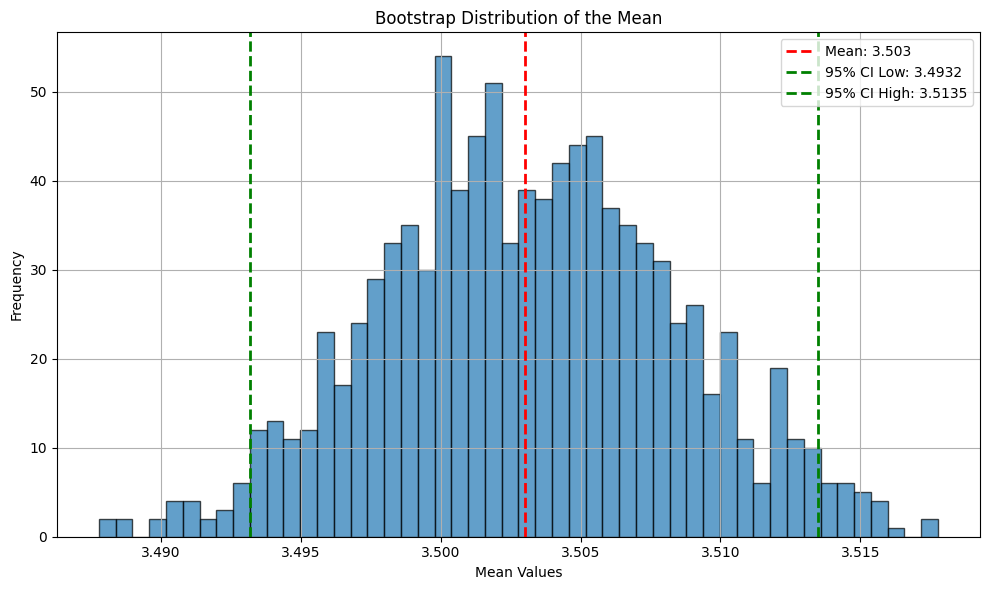

In [8]:
plot_bootstrap_single_distribution(tt)

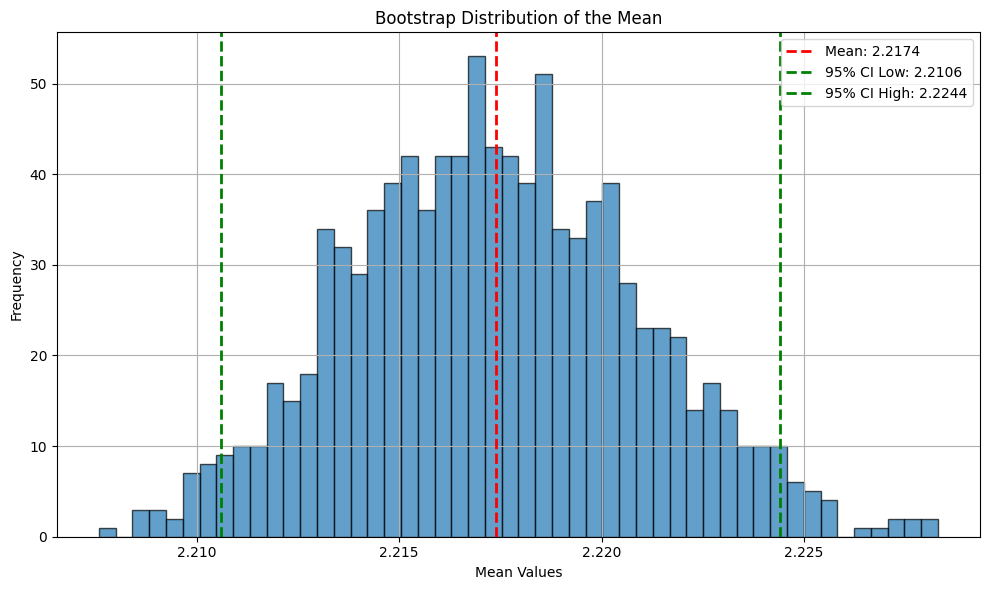

In [9]:
plot_bootstrap_single_distribution(bb)

In [10]:
t_confidence_interval(data, alpha=0.05)

NameError: name 'data' is not defined

In [ ]:
tt

{'mean': np.float64(3.503),
 'ci': (np.float64(3.4924), np.float64(3.5129)),
 'bootstrap_mean': np.float64(3.503),
 'bootstrap_means': array([3.4944901 , 3.50273381, 3.5053037 , 3.51298362, 3.50272126,
        3.49066283, 3.50447042, 3.50562035, 3.50845367, 3.50262031,
        3.51261407, 3.50667285, 3.50237477, 3.49428488, 3.50074643,
        3.50186176, 3.50539726, 3.51084428, 3.50453662, 3.49862161,
        3.5057815 , 3.50835423, 3.49761698, 3.50096674, 3.49910786,
        3.50050824, 3.50463007, 3.50874729, 3.50696961, 3.49291912,
        3.49934718, 3.50418992, 3.49289471, 3.49904551, 3.49700818,
        3.50105568, 3.50329842, 3.49884347, 3.49512333, 3.506652  ,
        3.50430913, 3.49830641, 3.49991554, 3.50015128, 3.50164694,
        3.50549861, 3.50293596, 3.50158326, 3.50330335, 3.4987794 ,
        3.50388561, 3.50391154, 3.49954959, 3.50206067, 3.51557777,
        3.501234  , 3.50148888, 3.50273318, 3.50964989, 3.50008988,
        3.5029673 , 3.49895282, 3.50382791, 3.5113

In [ ]:
t_confidence_interval(a['analytical_profit_post'].values, alpha=0.05)

{'mean': np.float64(3.503), 'ci': (np.float64(3.493), np.float64(3.513))}

In [21]:
a

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped
102749,FP_PK,pkc5826t,True,1,1,1.505550,0.322428,2025-04-14,1.169639,3.541821
102750,FP_PK,pk1x5p7h,True,0,5,0.000000,1.647251,2025-04-14,4.227316,8.718788
102751,FP_PK,pkrxm5bi,True,53,83,68.097595,128.163082,2025-04-14,52.364343,24.339525
102752,FP_PK,m7uvb5lk,True,5,12,2.510414,3.004318,2025-04-14,2.694952,9.833952
102753,FP_PK,pk3ayve7,True,0,1,0.000000,0.514251,2025-04-14,3.094316,4.718788
...,...,...,...,...,...,...,...,...,...,...
7934538,FP_PK,pknx1l1n,False,1,0,0.210713,0.000000,2025-04-14,2.326902,2.548259
7934539,FP_PK,pkbs1lzo,False,4,0,1.831355,0.000000,2025-04-14,0.447141,-1.028954
7934540,FP_PK,pklbp7bp,False,1,1,0.075827,0.025480,2025-04-14,2.508835,3.548259
7934541,FP_PK,pkqqufd1,False,0,1,0.000000,-0.148420,2025-04-14,2.422886,4.740663


In [36]:
d = bootstrap_diff_means(a, 'analytical_profit_post')

2025-04-16 16:25:06,430 INFO:
Observed Mean Diff: 0.0052
Bootstrap Mean Diff: 0.0056
Bootstrap 95% CI: (-0.0691, 0.0886)
Bootstrap P-value: 0.8910


In [37]:
f = bootstrap_diff_means(a, 'analytical_profit_post_cuped')

2025-04-16 16:29:24,414 INFO:
Observed Mean Diff: 0.0052
Bootstrap Mean Diff: 0.0049
Bootstrap 95% CI: (-0.0415, 0.0563)
Bootstrap P-value: 0.8370


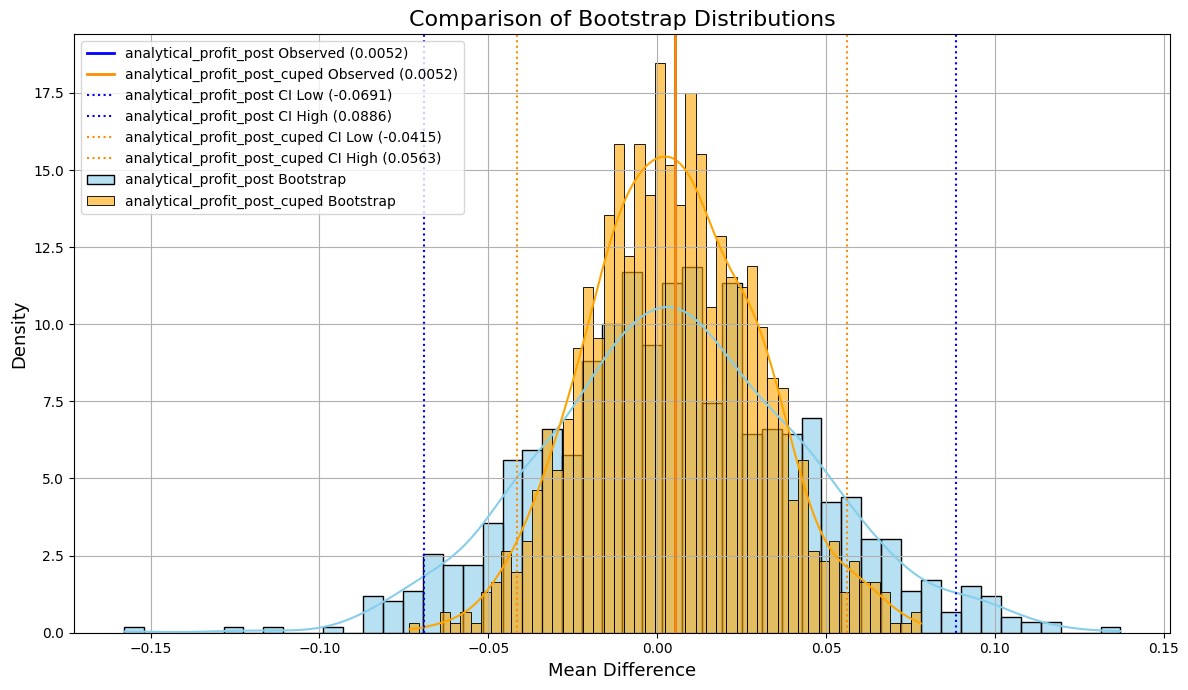

In [42]:
plot_two_bootstrap_distributions(d, f)

In [14]:
-0.0691 - 0.0886

-0.1577

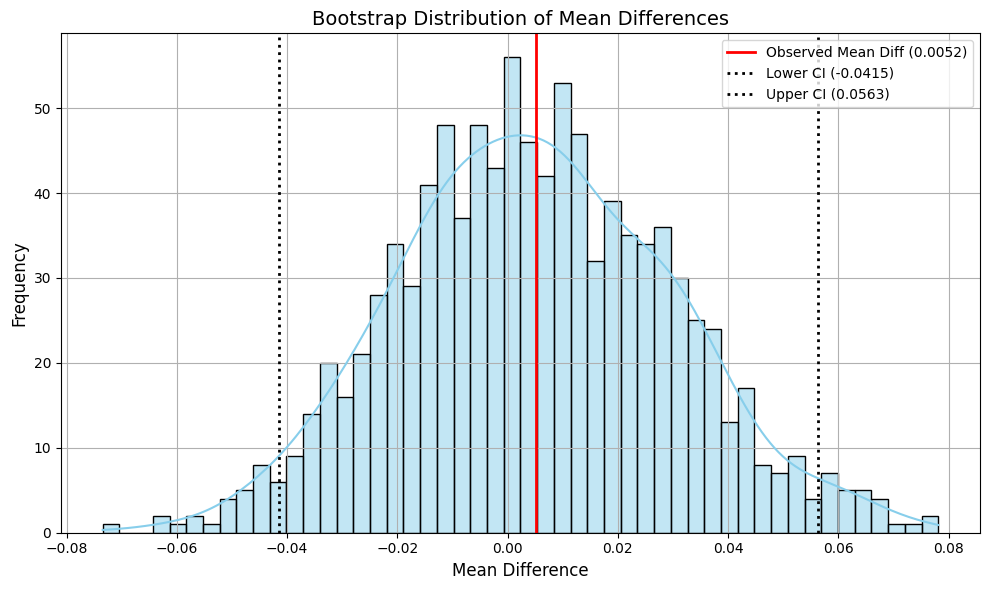

In [38]:
plot_bootstrap_distribution(f)

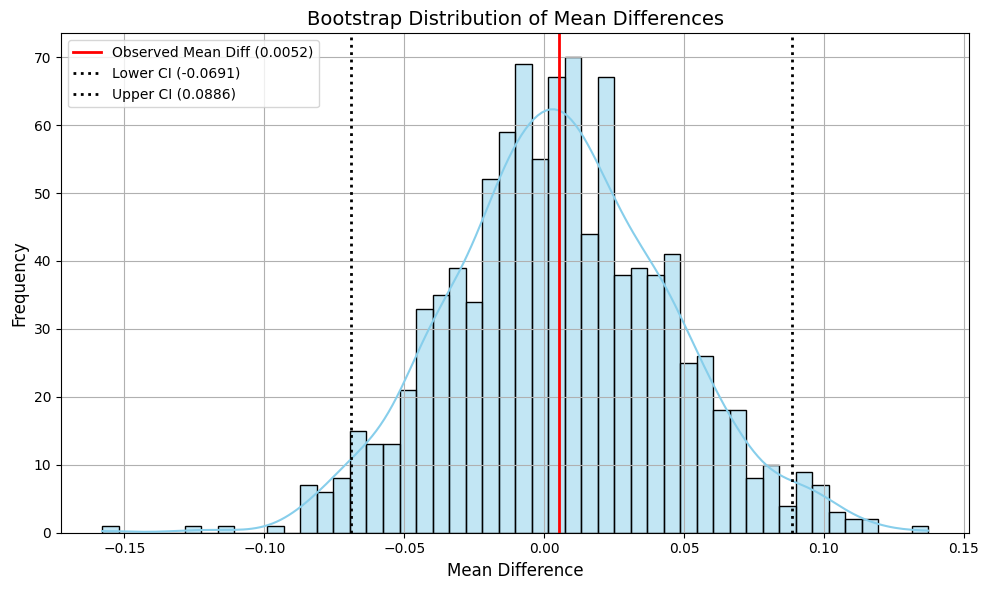

In [13]:
plot_bootstrap_distribution(d)

In [16]:
z = welchs_ttest_with_ci(a, 'analytical_profit_post')

Observed Mean Diff: 0.0052
T-statistic: 0.1324
P-value: 0.8947
95% CI: (-0.0714, 0.0818)


In [21]:
a

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped
102749,FP_PK,k4tki2jm7,True,12,15,3.596365,4.761793,2025-04-14,3.202523,4.595181
102750,FP_PK,pke53ytt,True,1,12,2.836783,27.525986,2025-04-14,26.840977,14.541821
102751,FP_PK,pkb95wnt,True,15,26,6.066853,11.939514,2025-04-14,7.536767,12.06428
102752,FP_PK,pkovt0mj,True,4,19,4.303371,15.434874,2025-04-14,13.061856,18.010919
102753,FP_PK,pkbar0tk,True,25,36,41.830172,55.450706,2025-04-14,9.885182,10.294607
...,...,...,...,...,...,...,...,...,...,...
7934538,FP_PK,q0uyy3fc,False,8,9,4.872751,6.268413,2025-04-14,3.187879,3.201429
7934539,FP_PK,pkbgj6ip,False,8,5,7.670347,3.206794,2025-04-14,-3.118635,-0.798571
7934540,FP_PK,pko8vjrw,False,8,0,24.163881,0.000000,2025-04-14,-25.456065,-5.798571
7934541,FP_PK,pklztxro,False,8,10,2.907831,5.030479,2025-04-14,4.229030,4.201429


In [23]:
apply_cuped_adjustment()


SyntaxError: invalid syntax (3761251409.py, line 1)

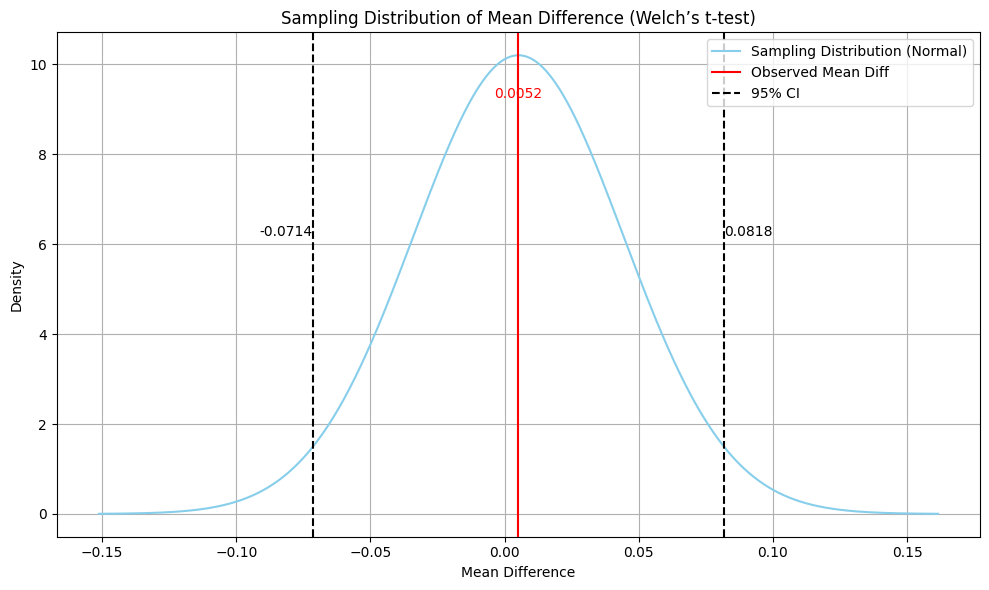

In [19]:
from scipy.stats import norm


# Your input values
observed_diff = np.float64(0.005175359110324962)
t_statistic = np.float64(0.13239070542770734)
p_value = np.float64(0.8946757393529482)
ci = (np.float64(-0.07144433735825026), np.float64(0.08179505557890018))
alpha = 0.05

# Estimate standard error from CI
z = norm.ppf(1 - alpha / 2)
se_diff = (ci[1] - observed_diff) / z

# Plotting function
def plot_ttest_distribution(observed_diff, se_diff, ci, alpha=0.05, n_points=1000):
    x = np.linspace(observed_diff - 4*se_diff, observed_diff + 4*se_diff, n_points)
    y = norm.pdf(x, loc=observed_diff, scale=se_diff)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="Sampling Distribution (Normal)", color='skyblue')

    # Observed difference
    plt.axvline(observed_diff, color='red', linestyle='-', label='Observed Mean Diff')
    plt.text(observed_diff, max(y)*0.9, f"{observed_diff:.4f}", color='red', ha='center', va='bottom', fontsize=10)

    # CI bounds
    plt.axvline(ci[0], color='black', linestyle='--', label=f'{100*(1-alpha):.0f}% CI')
    plt.axvline(ci[1], color='black', linestyle='--')
    plt.text(ci[0], max(y)*0.6, f"{ci[0]:.4f}", color='black', ha='right', va='bottom', fontsize=10)
    plt.text(ci[1], max(y)*0.6, f"{ci[1]:.4f}", color='black', ha='left', va='bottom', fontsize=10)

    # Labels and formatting
    plt.title("Sampling Distribution of Mean Difference (Welch’s t-test)")
    plt.xlabel("Mean Difference")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function with computed se_diff
plot_ttest_distribution(observed_diff, se_diff, ci, alpha)

In [ ]:
plot_ttest_distribution(0.005175359110324962, se_diff, ci, alpha=0.05, n_points=1000):

In [7]:
a = raw_cuped_cumm_df[raw_cuped_cumm_df['entity_id'] == "FP_PK"]

In [1]:
raw_cuped_cumm_df

NameError: name 'raw_cuped_cumm_df' is not defined

In [9]:
import matplotlib.pyplot as plt

results = bootstrap_diff_means(a, "orders_post_cuped")

# Convert % for plotting
for r in results:
    r["mean_pct"] = r["bootstrap_mean_diff"] * 100
    r["ci_low"] = r["ci"]["diff"][0] * 100
    r["ci_high"] = r["ci"]["diff"][1] * 100

# Plot
fig, ax = plt.subplots(figsize=(9, 3))

for i, r in enumerate(results):
    ax.errorbar(r["mean_pct"], i, xerr=[[r["mean_pct"] - r["ci_low"]], [r["ci_high"] - r["mean_pct"]]],
                fmt='o', capsize=5, capthick=2, label=r["label"])

    # Optional: background bar
    ax.axhspan(i - 0.3, i + 0.3, color='gray', alpha=0.05)

# Formatting
ax.axvline(0, color='gray', linestyle='--')
ax.set_yticks(range(len(results)))
ax.set_yticklabels([r["label"] for r in results])
ax.set_xlabel("Uplift (percentage points)")
ax.set_title("Bootstrapped Differences in Means")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

TypeError: string indices must be integers, not 'str'

In [29]:
CI_comparison_single(raw_cuped_cumm_df, "orders_post_cuped","PY_DO", holdout = True)

({'mean': np.float64(5.17), 'ci': (np.float64(5.068), np.float64(5.276))},
 {'mean': np.float64(5.17), 'ci': (np.float64(5.069), np.float64(5.271))})

In [4]:
CI_comparison_differences(raw_cuped_cumm_df, "orders_post_cuped","PY_DO")

2025-04-01 14:20:25,720 INFO:
Observed Mean Diff: 0.0303
Bootstrap Mean Diff: 0.0319
Bootstrap 95% CI: (-0.0709, 0.135)
Bootstrap P-value: 0.6338
Observed Mean Diff: 0.0303
T-statistic: 0.5801
P-value: 0.5619
95% CI: (-0.0720, 0.1326)


({'observed_diff': np.float64(0.03027363815769757),
  'bootstrap_mean': np.float64(0.0319),
  'ci': (np.float64(-0.0709), np.float64(0.135)),
  'p_value': np.float64(0.6338),
  'boot_diffs': array([ 0.05581707,  0.01527045,  0.05284401, ...,  0.08791726,
         -0.08888882,  0.12259612])},
 {'observed_diff': np.float64(0.03027363815769757),
  't_statistic': np.float64(0.5801041089113215),
  'p_value': np.float64(0.5618553928968157),
  'ci': (np.float64(-0.07202054200062476), np.float64(0.13256781831601988))})

In [15]:
a = raw_cuped_cumm_df[(raw_cuped_cumm_df["is_customer_holdout"] == True) & (raw_cuped_cumm_df["entity_id"] == "PY_DO")]

In [21]:
a

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date,analytical_profit_post_cuped,orders_post_cuped
50356,PY_DO,16496517,True,11,27,42.628823,90.977305,2025-03-31,52.081002,19.122292
50357,PY_DO,78054397,True,0,1,0.000000,2.754215,2025-03-31,9.396003,5.024267
50358,PY_DO,84376670,True,7,15,25.782875,14.553229,2025-03-31,-6.347449,11.450283
50359,PY_DO,59379790,True,2,3,0.251678,0.636564,2025-03-31,7.009498,4.860272
50360,PY_DO,67657819,True,11,7,34.286351,22.118214,2025-03-31,-7.866272,-0.877708
...,...,...,...,...,...,...,...,...,...,...
61790,PY_DO,20815034,True,0,4,0.000000,5.438421,2025-03-31,12.080209,8.024267
61791,PY_DO,16499131,True,15,18,39.712943,72.608401,2025-03-31,36.826977,5.794301
61792,PY_DO,89269107,True,0,5,0.000000,2.307820,2025-03-31,8.949608,9.024267
61793,PY_DO,41086030,True,3,0,3.558943,0.000000,2025-03-31,2.839960,0.778274


Group Mean: 5.1699
95% CI: (5.0680, 5.2763)


({'mean': np.float64(5.1699),
  'ci': (np.float64(5.068), np.float64(5.2763)),
  'boot_means': array([5.11838038, 5.08946885, 5.20810651, ..., 5.15020509, 5.13606836,
         5.14838947])},
 {'mean': np.float64(5.169944925255704),
  'ci': (np.float64(5.068666199884451), np.float64(5.271223650626958))})

In [142]:
raw_cuped_cumm_df = apply_cuped_adjustment(cleaned_cumm_df, entities, week_mondays)

Holdout - Entities:   0%|          | 0/2 [00:00<?, ?it/s]

Holdout - Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Holdout - Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Non-holdout - Entities:   0%|          | 0/2 [00:00<?, ?it/s]

Non-holdout - Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

Non-holdout - Weeks:   0%|          | 0/1 [00:00<?, ?it/s]

In [134]:
week_mondays

[datetime.date(2025, 3, 31)]

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Week:   0%|          | 0/1 [00:00<?, ?it/s]

2025-04-01 12:35:36,401 INFO:✅ Data uploaded to GCS at parquet_files/cuped_holdout_as_of_2025-03-31.parquet (overwritten)


In [127]:
raw_cuped_cumm_df.isna().sum()

entity_id                       0
customer_id                     0
is_customer_holdout             0
orders_pre                      0
orders_post                     0
analytical_profit_pre           0
analytical_profit_post          0
as_of_date                      0
analytical_profit_post_cuped    0
orders_post_cuped               0
dtype: int64

In [114]:
holdout = raw_cuped_cumm_df[(raw_cuped_cumm_df['is_customer_holdout'] == True) & (raw_cuped_cumm_df['entity_id'] == 'PY_DO')]
non_holdout = raw_cuped_cumm_df[(raw_cuped_cumm_df['is_customer_holdout'] == False) & (raw_cuped_cumm_df['entity_id'] == 'PY_DO')]

Group Mean: 8.1501
95% CI: (8.1165, 8.1852)
Group Mean: 8.1501
95% CI: (8.0920, 8.2083)


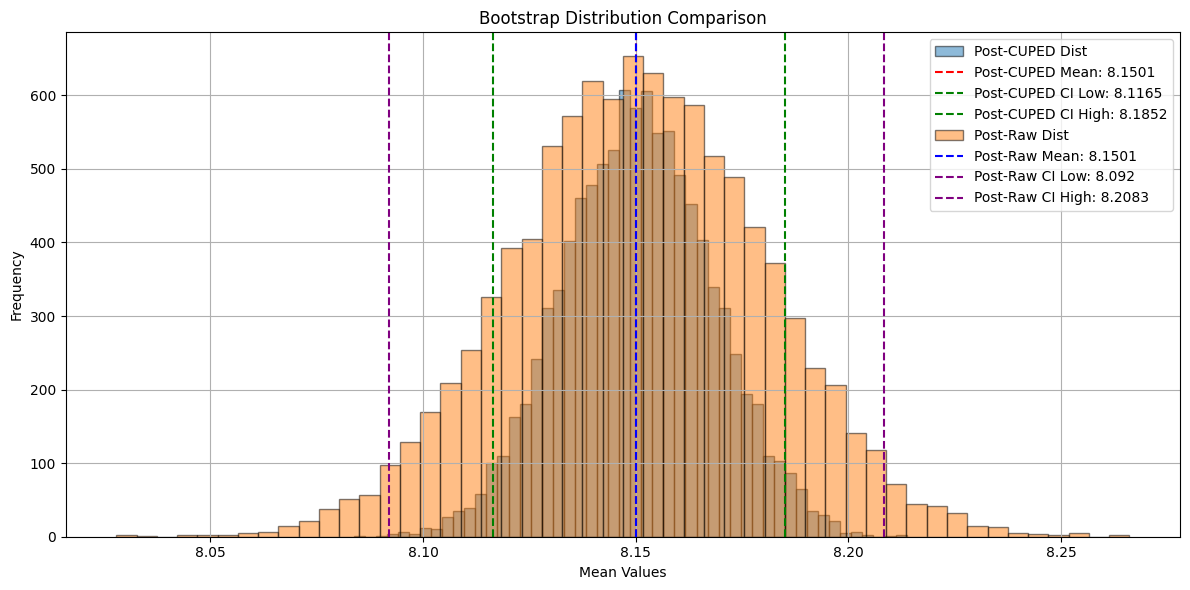

In [116]:
a = bootstrap_single_group(non_holdout, "analytical_profit_post_cuped")
b = bootstrap_single_group(non_holdout, "analytical_profit_post")

plot_bootstrap_comparison(a, "Post-CUPED", b, "Post-Raw")

In [101]:
a = t_confidence_interval(h["analytical_profit_post_cuped"])
b = t_confidence_interval(h["analytical_profit_post"])

In [102]:
a

{'mean': np.float64(8.12553977582006),
 'ci': (np.float64(7.878891231985968), np.float64(8.372188319654153))}

In [103]:
b

{'mean': np.float64(8.12553977582006),
 'ci': (np.float64(7.713358693671499), np.float64(8.537720857968623))}

In [83]:
hb_cuped = bootstrap_single_group(h,"")
hb_non_cuped = bootstrap_single_group(nh)

TypeError: bootstrap_single_group() missing 1 required positional argument: 'adjusted_metric'

In [75]:
from sklearn.linear_model import Ridge

X = holdout[['analytical_profit_pre']]
y = holdout['analytical_profit_post']

ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

theta_ridge = ridge.coef_[0]

holdout["cuped_ridge"] = (
    holdout['analytical_profit_post'] - theta_ridge * (holdout['analytical_profit_pre'] - holdout['analytical_profit_pre'].mean())
)

print(holdout['cuped_ridge'].mean())

print("Original variance:", holdout['cuped_standard'].var())
print("CUPED variance:   ", holdout['cuped_ridge'].var())

X = non_holdout[['analytical_profit_pre']]
y = non_holdout['analytical_profit_post']

ridge = Ridge(alpha=1.0)
ridge.fit(X, y)

theta_ridge = ridge.coef_[0]

non_holdout["cuped_ridge"] = (
    non_holdout['analytical_profit_post'] - theta_ridge * (non_holdout['analytical_profit_pre'] - non_holdout['analytical_profit_pre'].mean())
)

print(non_holdout['cuped_ridge'].mean())

print("Original variance:", non_holdout['cuped_standard'].var())
print("CUPED variance:   ", non_holdout['cuped_ridge'].var())



8.125539775820057
Original variance: 181.11610552838715
CUPED variance:    181.11610304667784
8.150088258859702
Original variance: 169.93911518808042
CUPED variance:    169.9391151870383


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_84025/2251284275.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holdout["cuped_ridge"] = (
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_84025/2251284275.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_holdout["cuped_ridge"] = (


In [56]:
group_a = test[test["is_customer_holdout"] == False]
group_b = test[test["is_customer_holdout"] == True]

In [57]:
a = bootstrap_single_group(
    group_a,
    "orders_post"
)

b = bootstrap_single_group(
    group_b,
    "orders_post"
)

Group Mean: 5.2002
95% CI: (5.1761, 5.2237)
Group Mean: 5.1699
95% CI: (5.0045, 5.3362)


In [37]:
a = bootstrap_with_pvalue(test, "orders_post")

2025-03-31 16:55:15,787 INFO:
Observed Mean Diff: 0.0303
Bootstrap Mean Diff: 0.0291
Bootstrap 95% CI: (-0.1427, 0.1965)
Bootstrap P-value: 0.7438


Observed Mean Diff: 0.0303
T-statistic: 0.3533
P-value: 0.7239
95% CI: (-0.1377, 0.1982)


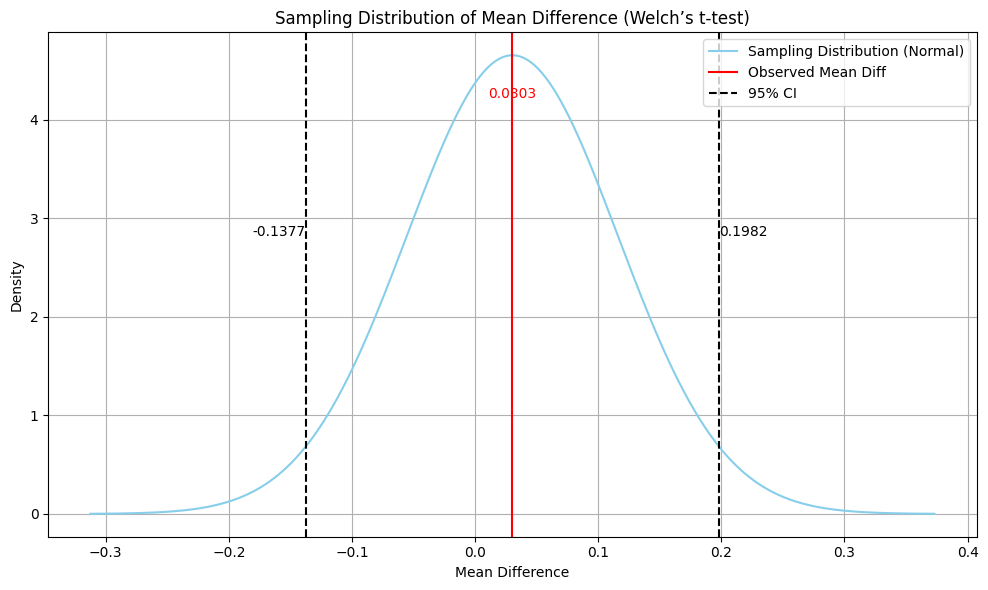

In [47]:
from scipy.stats import norm

result_ttest = welchs_ttest_with_ci(test, "orders_post")

# Recalculate standard error using same logic as in your function
group_a = test[test["is_customer_holdout"] == False]["orders_post"].values
group_b = test[test["is_customer_holdout"] == True]["orders_post"].values

se_diff = np.sqrt(np.var(group_a, ddof=1) / len(group_a) + np.var(group_b, ddof=1) / len(group_b))

# Now plot
plot_ttest_distribution(
    observed_diff=result_ttest["observed_diff"],
    se_diff=se_diff,
    ci=result_ttest["ci"],
    alpha=0.05
)


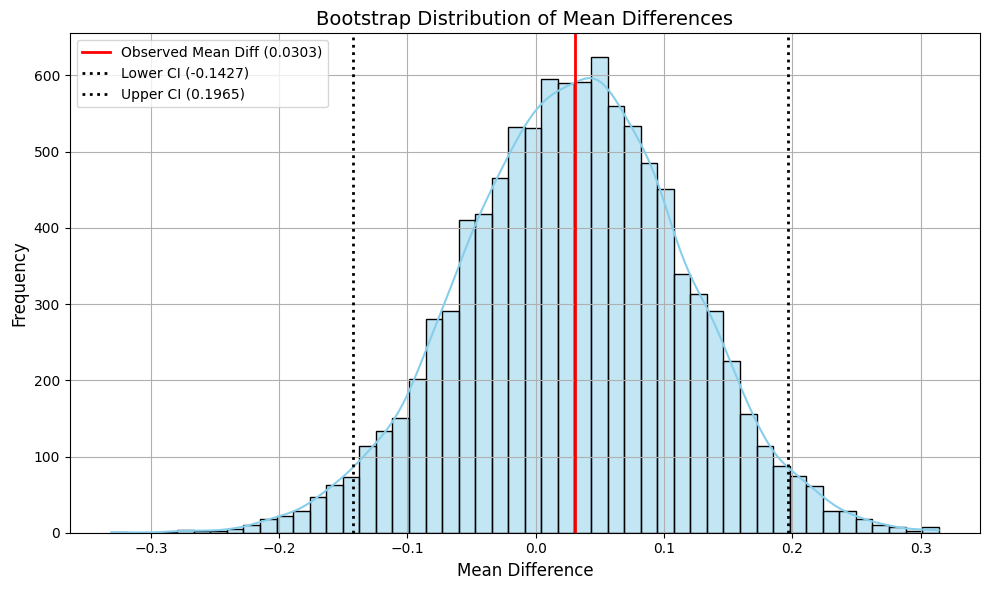

In [39]:
plot_bootstrap_distribution(a)


In [ ]:
cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['entity_id'] == 'PY_DO')]

In [18]:
# Example: conversion rates in two groups
a = cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['is_customer_holdout'] == True)]['orders_post']
b = cleaned_cumm_df[(cleaned_cumm_df['entity_id'] == 'PY_DO') & (cleaned_cumm_df['is_customer_holdout'] == False)]['orders_post']

result = bootstrap_ttest(a, b)

print(f"Observed diff: {result['observed_diff']:.4f}")
print(f"P-value: {result['p_value']:.4f}")
print(f"95% CI: {result['ci']}")

Observed diff: -0.0303
P-value: 0.7383
95% CI: (np.float64(-0.19423178411817624), np.float64(0.13973274537831404))


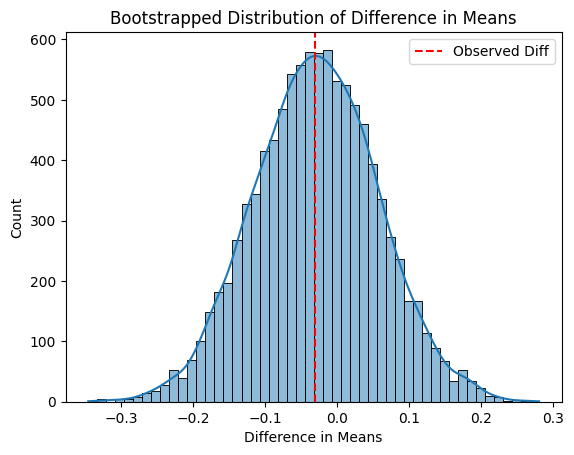

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(result["boot_diffs"], bins=50, kde=True)
plt.axvline(result["observed_diff"], color='red', linestyle='--', label='Observed Diff')
plt.title("Bootstrapped Distribution of Difference in Means")
plt.xlabel("Difference in Means")
plt.legend()
plt.show()

In [88]:
# ## Define the list of entities that have data in marketing tables ## 
# ## --> rest of the data is extracted from DPS with condition not in the following entities ##

# # mkt_entity_id = tuple(set((
# #     'FP_PK','PY_DO','PY_BO', 'FP_TW', 
# #     'PY_PY', 'DJ_CZ', 'PY_EC','MJM_AT' ,'PY_PE', 'PY_AR',
# #     'PY_GT','PY_SV' ,'FP_PH','PY_NI' ,'NP_HU' ,'FP_MM','EF_GR',
# #     'AP_PA','YS_TR', 'PY_UY' ,'OP_SE' ,'PY_CL' ,'FP_BD' ,'FP_SG',
# #     'FO_NO' ,'PY_CR', 'FP_LA','PY_HN', 'FP_MY' ,'FP_TH', 'FY_CY',
# #     'PY_VE','PO_FI','TB_QA','TB_OM','TB_KW','TB_JO','TB_IQ',
# #     'TB_BH','TB_AE','HS_SA'
# # )))

# mkt_entity_id = (
#     'FP_PK','PY_DO'
# )


# client = initialize_bigquery_client(project)

# final_df = pd.DataFrame()  # Empty DataFrame to store the results

# for m in week_mondays:
#     print(f"Querying for week starting {m}")
    
#     # Run your query
#     test = client.query(marketing_data(mkt_entity_id, m)).to_dataframe()

#     # Add the as_of_date column
#     test["as_of_date"] = m

#     # Append to the final dataframe
#     final_df = pd.concat([final_df, test], ignore_index=True)

In [89]:
# get_cumm_data(project, mkt_entity_id, week_mondays)

In [77]:
week_mondays

[datetime.date(2025, 2, 3),
 datetime.date(2025, 2, 10),
 datetime.date(2025, 2, 17),
 datetime.date(2025, 2, 24),
 datetime.date(2025, 3, 3),
 datetime.date(2025, 3, 10),
 datetime.date(2025, 3, 17),
 datetime.date(2025, 3, 24)]

In [70]:
# extract_data(project, get_marketing_data(mkt_entity_id, '2025-02-03'), get_dps_data(mkt_entity_id, '2025-02-03'))

In [71]:
# a = fill_nans(final_df)

In [72]:
# b = drop_users_with_no_data(a)

In [73]:
# b

In [74]:
# c = b[b['as_of_date'] == date(2025, 2, 3)]


In [75]:
# d = c[c['entity_id'] == 'FP_PK']

In [76]:
# d.describe()

<Axes: >

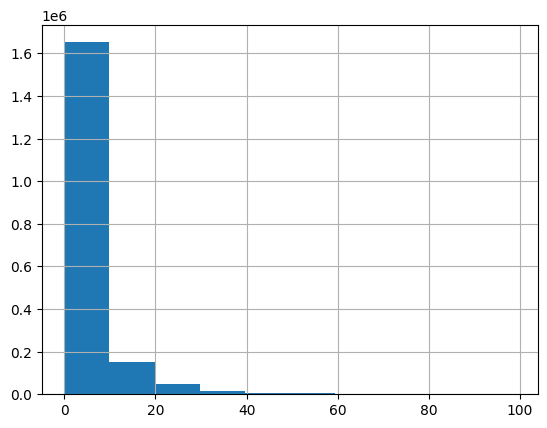

In [45]:
d[d['orders_pre'] < ]['orders_pre'].hist()

In [36]:
d[d['orders_post'] > 100]

,entity_id,customer_id,is_customer_holdout,orders_pre,orders_post,analytical_profit_pre,analytical_profit_post,as_of_date
1912,FP_PK,pkl5vh4v,False,299,162,-232.459968,-139.015658,2025-02-03
30450,FP_PK,pkmi7z73,False,180,101,129.225454,68.925644,2025-02-03
40095,FP_PK,pkfuznbn,False,421,115,-374.943772,-101.499222,2025-02-03
51087,FP_PK,pkqfcp46,False,153,102,161.496542,90.558404,2025-02-03
52232,FP_PK,pkrr6mgt,False,25,201,-17.522617,-171.586692,2025-02-03
63715,FP_PK,pkt0qzds,False,824,375,-717.823972,-329.789174,2025-02-03
92675,FP_PK,q2jnh3sa,False,154,103,69.738388,43.793499,2025-02-03
96438,FP_PK,pkc3pqe1,False,236,108,178.419564,85.678784,2025-02-03
99884,FP_PK,pkq9rg9b,False,86,203,-41.419323,-84.283658,2025-02-03
105347,FP_PK,pkzmz6d6,False,203,106,175.247182,77.061637,2025-02-03


In [ ]:
df = drop_users_with_no_data(raw_data)